In [2]:
import pandas as pd 
import numpy as np 
import os

from matplotlib import pyplot as plt 
import seaborn as sbn

import pickle as pkl

# Data Organization


# Functional Data 

In [21]:
viab1 = pd.read_excel('./../data/H190923/H100923_K562_viability.xlsx', engine='openpyxl')

viab1 = viab1.rename({'Das_0.625':'dasatinib_0.625', 'Das_1.25':'dasatinib_1.25', 'Das_2.5':'dasatinib_2.5', 'Das_5':'dasatinib_5', 'Das_10':'dasatinib_10',
       'Das_100':'dasatinib_100', 'Das_1000':'dasatinib_1000', '10uM_Tramet':'trametinib_10000', '10uM_MK2206':'MK2206_10000'}, axis=1)
viab1 = viab1.reset_index(drop=False)
viab1 = viab1.set_index(['index', 'Un']).stack().reset_index()
viab1 = viab1.assign(inhibitor=[x.split('_')[0] for x in viab1.level_2], conc_nm=[x.split('_')[1] for x in viab1.level_2])
viab1 = viab1.drop(['index', 'level_2'], axis=1).rename({'Un':'control_OD', 0:'optical_density'}, axis=1)
viab1 = viab1.assign(cell_viab=lambda x: x.optical_density/x.control_OD)
viab1.cell_viab = viab1.cell_viab.astype(float)
viab1.conc_nm = viab1.conc_nm.astype(float)
viab1 = viab1.assign(cell_line='k562')

# average across replicates
viab1 = viab1.groupby(['inhibitor', 'conc_nm', 'cell_line']).mean().reset_index()

print('shape', viab1.shape)
viab1.head()

shape (27, 6)


,control_OD,optical_density,inhibitor,conc_nm,cell_viab,cell_line
0,15990000,6819000,dasatinib,0.625,0.426454,k562
1,15990000,2979000,dasatinib,1.250,0.186304,k562
2,15990000,815200,dasatinib,2.500,0.050982,k562
3,15990000,409700,dasatinib,5.000,0.025622,k562
4,15990000,421900,dasatinib,10.000,0.026385,k562


In [4]:
viab1.dtypes

inhibitor           object
conc_nm            float64
cell_line           object
control_OD         float64
optical_density    float64
cell_viab          float64
dtype: object

# positive controls? 

I am assuming OD=0 is all cells dead ... valid. 

[12:00 PM] Nathaniel Evans  
    Hi Samuel, another question on the drug data - I don't see a positive control (all dead cells) was this already accounted for? e.g., does an optical density of 0 mean all cells are dead?   
​[1:53 PM] Samuel Tsang  
    I did not include one in these assays because the reagent that I used to detect viability has a really low background (couple hundreds optical density values) vs the one with live cells always show reads in millions  
​[1:53 PM] Nathaniel Evans  
    gotcha, so we can assume a well of all dead cells are pretty close to 0?   
​[1:54 PM] Samuel Tsang  
    yes  


In [22]:
viab1.groupby(['inhibitor', 'conc_nm']).agg(['mean','max', 'min'])#.assign(log_conc = lambda x: np.log10(x.conc_nm))

control_OD                     optical_density  \
                              mean       max       min            mean   
inhibitor  conc_nm                                                       
MK2206     10000.000  1.622667e+07  16790000  15900000    4.090333e+04   
dasatinib  0.625      1.622667e+07  16790000  15900000    6.782333e+06   
           1.250      1.622667e+07  16790000  15900000    2.865667e+06   
           2.500      1.622667e+07  16790000  15900000    7.480667e+05   
           5.000      1.622667e+07  16790000  15900000    3.811667e+05   
           10.000     1.622667e+07  16790000  15900000    3.903000e+05   
           100.000    1.622667e+07  16790000  15900000    2.700333e+05   
           1000.000   1.622667e+07  16790000  15900000    7.236333e+05   
trametinib 10000.000  1.622667e+07  16790000  15900000    4.711333e+06   

                                       cell_viab                      
                          max      min      mean       max       min  
inhibitor  conc_nm                                                    
MK2206     10000.000    44160    38480  0.002519  0.002630  0.002420  
dasatinib  0.625      6819000  6735000  0.418273  0.427233  0.401132  
           1.250      2979000  2749000  0.176691  0.186304  0.170876  
           2.500       815200   704000  0.046146  0.050982  0.043180  
           5.000       409700   337100  0.023550  0.025622  0.020077  
           10.000      421900   363200  0.024094  0.026385  0.021632  
           100.000     294000   252500  0.016656  0.018386  0.015700  
           1000.000    738600   702000  0.044613  0.046191  0.043496  
trametinib 10000.000  4825000  4521000  0.290721  0.303459  0.269267

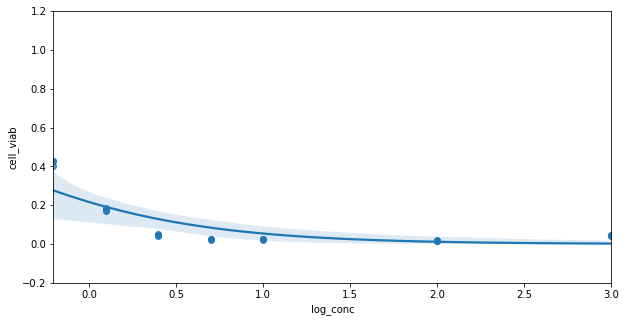

In [34]:
#plt.figure(figsize=(10,5))
#sbn.regplot(x='log_conc', y='cell_viab', data=viab2[viab2.inhibitor=='dasatinib'], logistic=True)
#plt.xscale('log')#
#plt.ylim((-0.2, 1.2))
#plt.xlim((-0.1, 3))
#plt.show()

# live cell reporter imaging 

In [6]:
clover = pd.read_csv('../data/H190923/clover_all_cell.csv')
print('shape', clover.shape)
print('unique tracks', clover.track_index.unique().shape)
clover.head()

shape (2051, 60)
unique tracks (2051,)


,track_index,0.0,0.2,0.5,0.8,1.0,1.2,1.5,1.8,2.0,...,12.2,12.5,12.8,13.0,13.2,13.5,13.8,site,cell__treatment,median
0,82_1000111247_k562_erk_akt__untreated,0.699047,0.860223,0.833703,0.876799,0.744755,0.761428,0.678657,0.811268,0.930258,...,0.970378,0.994650,0.980010,0.965371,0.950731,0.936091,0.921452,82,k562_erk_akt__untreated,0.890648
1,78_1000101697_k562_erk_akt__untreated,0.666206,0.583154,0.464076,0.401721,0.574265,0.628919,0.533323,0.639510,0.808772,...,0.868933,0.815478,0.828062,0.878905,0.919059,0.873078,0.967574,78,k562_erk_akt__untreated,0.881022
2,77_1000098381_k562_erk_akt__untreated,0.646522,0.419623,0.636420,0.608784,0.593370,0.594475,0.764531,0.781966,0.703256,...,0.972532,0.982428,0.992323,1.002218,0.924450,0.871228,0.845635,77,k562_erk_akt__untreated,0.870311
3,80_1000105940_k562_erk_akt__untreated,0.954352,0.940184,0.905822,0.804807,0.908674,0.909088,0.966587,0.941461,0.970301,...,0.860622,0.777151,0.870791,0.847924,0.885931,0.924960,0.834446,80,k562_erk_akt__untreated,0.864910
4,4_1000007026_k562_erk_akt__untreated,0.731499,0.644271,0.565533,0.405811,0.538459,0.716891,0.771548,0.708265,0.789968,...,0.851626,0.782360,0.926506,0.895508,0.864509,0.833511,0.804048,4,k562_erk_akt__untreated,0.848976


In [7]:
mscarlet = pd.read_csv('../data/H190923/mscarlet_all_cell.csv')
print('shape', mscarlet.shape)
print('unique tracks', mscarlet.track_index.unique().shape)
mscarlet.head()

shape (2903, 60)
unique tracks (2903,)


,track_index,0.0,0.2,0.5,0.8,1.0,1.2,1.5,1.8,2.0,...,12.2,12.5,12.8,13.0,13.2,13.5,13.8,site,cell__treatment,median
0,77_1000096839_k562_erk_akt__untreated,0.733356,0.730359,0.855087,0.979815,0.906416,0.783687,0.836431,0.889175,0.941919,...,0.702249,0.756292,0.621653,0.664888,0.708122,0.678550,0.738165,77,k562_erk_akt__untreated,0.857266
1,77_1000097173_k562_erk_akt__untreated,0.763494,0.882065,0.902098,0.812704,0.897095,0.868367,0.999787,0.783350,0.830576,...,0.818765,0.710451,0.678635,0.657997,0.699026,0.710898,0.721814,77,k562_erk_akt__untreated,0.851995
2,80_1000106218_k562_erk_akt__untreated,0.971281,0.955617,0.955654,0.955691,0.955729,0.927540,0.868079,0.670122,0.706057,...,0.884929,0.838210,0.822187,0.806164,0.788010,0.594563,0.648845,80,k562_erk_akt__untreated,0.833987
3,77_1000099363_k562_erk_akt__untreated,0.402566,0.732173,0.713618,0.828868,0.823853,0.844749,0.905638,0.867922,0.830207,...,0.768637,0.751322,0.799806,0.747896,0.781835,0.815773,0.880508,77,k562_erk_akt__untreated,0.829538
4,79_1000103272_k562_erk_akt__untreated,0.755541,0.808022,0.860503,0.912983,0.965464,0.976070,0.918214,0.836081,0.720845,...,0.839855,0.737728,0.791401,0.813331,0.914442,0.926692,0.700295,79,k562_erk_akt__untreated,0.823757


In [8]:
# grab time 
time = clover.columns[1:-3]

# create new time designators + selectors for later 
clover_selector = [f'erk_time(h)={x}' for x in time]
mscarlet_selector = [f'akt_time(h)={x}' for x in time]

# update time cols 
clover = clover.rename({x:f'erk_time(h)={x}' for x in time}, axis=1)
mscarlet = mscarlet.rename({x:f'akt_time(h)={x}' for x in time}, axis=1)
clover = clover.rename({'median':'erk_median', 'site':'erk_site'}, axis=1)
mscarlet = mscarlet.rename({'median':'akt_median', 'site':'akt_site'}, axis=1)

In [9]:
# merge clover and mscarlet
data = clover.merge(mscarlet, on=['track_index', 'cell__treatment'])

print('shape', data.shape)
print('unique tracks', data.track_index.unique().shape)

shape (816, 118)
unique tracks (816,)


## create `conc_nm` and `inhibtor` columns

In [10]:
# eda 
data.groupby('cell__treatment')['track_index'].count()

cell__treatment
k562_erk_akt__0.625nm_dasatinib     91
k562_erk_akt__1.25nm_dasatinib      83
k562_erk_akt__1000nm_dasatinib      91
k562_erk_akt__100nm_dasatinib      103
k562_erk_akt__10nm_dasatinib        76
k562_erk_akt__10um trametinib       85
k562_erk_akt__10um_mk2206           27
k562_erk_akt__2.5nm_dasatinib       99
k562_erk_akt__5nm_dasatinib         81
k562_erk_akt__untreated             80
Name: track_index, dtype: int64

In [11]:
treatment_map = {'0.625nm_dasatinib':(0.625,'dasatinib'),
 '1.25nm_dasatinib':(1.25,'dasatinib'), 
 '1000nm_dasatinib':(1000,'dasatnib'),
 '100nm_dasatinib':(100,'dasatinib'), 
 '10nm_dasatinib':(10,'dasatinib'), 
 '10um trametinib':(10e3,'trametinib'),
 '10um_mk2206':(10e3,'MK2206'),
 '2.5nm_dasatinib':(2.5,'dasatinib'),
 '5nm_dasatinib':(5,'dasatnib'),
 'untreated':(0.0,'none')}

In [12]:
data = data.assign(conc_nm=[treatment_map[x.split('__')[-1]][0] for x in data.track_index],
                  inhibitor=[treatment_map[x.split('__')[-1]][1] for x in data.track_index],
                  cell_line='k562')

## merge viability data 

In [13]:
data = data.merge(viab1, on=['cell_line', 'inhibitor', 'conc_nm'], how='left', validate='m:1')

print('shape', data.shape)
print('unique tracks', data.track_index.unique().shape)

shape (816, 124)
unique tracks (816,)


In [14]:
# set cell viab nan's to 1 - only nans should be no treatment
data.cell_viab = data.cell_viab.fillna(1.)
data.head()

,track_index,erk_time(h)=0.0,erk_time(h)=0.2,erk_time(h)=0.5,erk_time(h)=0.8,erk_time(h)=1.0,erk_time(h)=1.2,erk_time(h)=1.5,erk_time(h)=1.8,erk_time(h)=2.0,...,akt_time(h)=13.5,akt_time(h)=13.8,akt_site,akt_median,conc_nm,inhibitor,cell_line,control_OD,optical_density,cell_viab
0,78_1000101697_k562_erk_akt__untreated,0.666206,0.583154,0.464076,0.401721,0.574265,0.628919,0.533323,0.639510,0.808772,...,0.498220,0.523217,78,0.496346,0.0,none,k562,NaN,NaN,1.0
1,77_1000098381_k562_erk_akt__untreated,0.646522,0.419623,0.636420,0.608784,0.593370,0.594475,0.764531,0.781966,0.703256,...,0.630918,0.623906,77,0.503596,0.0,none,k562,NaN,NaN,1.0
2,4_1000007026_k562_erk_akt__untreated,0.731499,0.644271,0.565533,0.405811,0.538459,0.716891,0.771548,0.708265,0.789968,...,0.835404,0.626950,4,0.642910,0.0,none,k562,NaN,NaN,1.0
3,2_1000002957_k562_erk_akt__untreated,0.860727,0.690160,0.633814,0.886553,0.915976,0.856283,0.759563,0.927312,0.948254,...,0.749850,0.384942,2,0.541348,0.0,none,k562,NaN,NaN,1.0
4,82_1000111191_k562_erk_akt__untreated,0.547424,0.521789,0.448863,0.573173,0.504300,0.525133,0.493384,0.638652,0.621023,...,0.684539,0.720796,82,0.609912,0.0,none,k562,NaN,NaN,1.0


# Add metadata to `dataframe` and save as `.pkl` 

In [15]:
data.attrs['clover_selector'] = clover_selector 
data.attrs['mscarlet_selector'] = mscarlet_selector
data.attrs['treatment_map'] = treatment_map
data.attrs['meta'] = {'pathways':('erk','akt'), 'cell_line':'k562', 'treatments':('dasatinib', 'trametinib', 'mk2206')}

In [16]:
with open('../data/H190923.pkl', 'wb') as f: 
    pkl.dump(data, f)